In [10]:
import json 
import random 
import math
class Field:
    #def __init__(self, field):
        #self.field = figures
        #self.w_width = self.field['main_rectangle'][0][0]
        #self.w_length = self.field['main_rectangle'][0][1]
    def __init__(self, path):
        with open(path, "r") as f:
            self.field = json.loads(f.read())
        self.w_width = self.field['main_rectangle'][0][0]
        self.w_length = self.field['main_rectangle'][0][1]
        
class Robot(Field):
    def __init__(self, x = 1, y = 0.5, yaw = 0):
 
        self.x = x          # robot's x coordinate
        self.y = y          # robot's y coordinate
        self.orientation = yaw  # robot's orientation
         
        self.forward_noise = 0.05   # noise of the forward movement
        self.turn_noise = 0.1      # noise of the turn
        self.sense_noise = 0.3    # noise of the sensing
        
    def set_coord(self, new_x, new_y, new_orientation):
        #if new_orientation < 0 or new_orientation >= 2 * pi:
        #   raise ValueError('Orientation must be in [0..2pi]')

        self.x = float(new_x)
        self.y = float(new_y)
        self.orientation = float(new_orientation)
        
    def set_noise(self, new_forward_noise, new_turn_noise, new_sense_noise):
 
        self.forward_noise = float(new_forward_noise)
        self.turn_noise = float(new_turn_noise)
        self.sense_noise = float(new_sense_noise)  
    
    def sense(self, landmarks):
        z = []
        for i in range(len(landmarks)):
            dist = math.sqrt((self.x - landmarks[i][0]) ** 2 
                             + (self.y - landmarks[i][1]) ** 2)
            dist += random.gauss(0.0, self.sense_noise)
            z.append(dist)
        #print("z = ", z)
        return z
    
    
    def move(self, turn, forward):
        # turn, and add randomness to the turning command
        orientation = self.orientation + float(turn) + random.gauss(0.0, self.turn_noise)
        orientation %= 2 * math.pi

        # move, and add randomness to the motion command
        dist = float(forward) + random.gauss(0.0, self.forward_noise)
        x = self.x + (math.cos(orientation) * dist)
        y = self.y + (math.sin(orientation) * dist)
        #x = math.copysign(Field.w_width, x) if math.fabs(x) >= Field.w_width
        if math.fabs(x) >= field.w_width:
            x = math.copysign(field.w_width/2.0, x)
        if math.fabs(y) >= field.w_length:
            y = math.copysign(field.w_length/2.0, y)
        # set particle
        res = Robot()
        res.set_coord(x, y, orientation)
        self.x = x
        self.y = y
        self.orientation = orientation
        #res.set_noise(self.forward_noise, self.turn_noise, self.sense_noise)

        return res
    
    def gaussian(self, mu, sigma, x):
        # calculates the probability of x for 1-dim Gaussian with mean mu and var. sigma
        return math.exp(-((mu - x) ** 2) / (sigma ** 2)) / math.sqrt(2.0 * math.pi * (sigma ** 2))
    
    def measurement_prob(self, measurement): #particle weight calculation
        prob = 1.0
        for i in range(len(landmarks)):
            dist = math.sqrt((self.x - landmarks[i][0]) ** 2 + (self.y - landmarks[i][1]) ** 2)
            #print(self.gaussian(dist, self.sense_noise, measurement[i]))
            prob *= self.gaussian(dist, self.sense_noise, measurement[i][0]) 
        #print("prob ", prob)
        return prob
    
    def update_coord(self, particles):
        x = 0.0
        y = 0.0 
        orientation = 0.0
        for i in range(len(particles)):
            x += particles[i][0].x * particles[i][1]
            y += particles[i][0].y * particles[i][1]
            orientation += particles[i][0].orientation * particles[i][1]
        self.x = x
        self.y = y
        #self.orientation = orientation
    
    def return_coord(self):
        return self.x, self.y, self.orientation

In [288]:
class ParticleFilter():
    def __init__(self, myrobot, field,
                 n = 300, forward_noise = 0.025, 
                 turn_noise = 0.1, sense_noise = 0.3):
        self.forward_noise = forward_noise
        self.turn_noise = turn_noise
        self.sense_noise = sense_noise
        self.n = n  # number of particles
        self.myrobot = myrobot
        self.p = [] 
        
        for i in range(self.n):
            x = Robot((random.random()-0.5)*field.w_width, (random.random()-0.5)*field.w_length, random.random()*math.pi*2)
            #x.set_noise(forward_noise, turn_noise, 0)
            self.p.append([x,0]) 
        
            
    def step(self, landmarks):
        
        self.myrobot = self.myrobot.move(0, 1.0)
        z = self.myrobot.sense(landmarks)

        # now we simulate a robot motion for each of
        # these particles
        p_tmp = []
        for i in range(self.n):
            p_tmp.append([self.p[i][0].move(0, 1.0),0])
        self.p = p_tmp
        self.myrobot.update_coord(p_tmp)
        
        return p_tmp
    
    def do_n_steps(self, n_steps):
        for i in range(n_steps):
            self.step()
            
    def resampling(self, measurement, landmarks):
        p_tmp = []
        w = []
        S = 0
        for i in range(self.n):
            z = self.myrobot.sense((landmarks))
            #z = get_measurements(landmarks)
            w.append(self.p[i][0].measurement_prob(measurement))
            S += (w[i])
        #print("px =  ",p[i][0].x)
        #print("w ", w )
        for i in range(self.n):
            w[i] = w[i]/S
            S += w[i]
        index = int(random.random() * self.n)
        beta = 0.0
        mw = max(w)
        #pd.Series(w).hist(bins=20)
        #print(mw)
        for i in range(self.n):
            beta += random.random() * 2.0 * mw
            while beta > w[index]:
                beta -= w[index]
                index = (index + 1) % self.n
            p_tmp.append([self.p[index][0],w[index]])
        #print(p_tmp)
        S = 0
        for i in range(len(p_tmp)):
            S += p_tmp[i][1]
        for i in range(len(p_tmp)):
            p_tmp[i][1] /= S
        
        self.p = p_tmp  
        self.myrobot.update_coord(p_tmp) 
        return w, p_tmp

In [11]:

field = Field("untitled.json")

AttributeError: 'Field' object has no attribute 'weght'

In [300]:
import matplotlib.pylab as plt
def visualization(robot, step, p, pr, factor = 7 
                 ):
    
    plt.figure("Robot in the world",figsize=(field.w_width, field.w_length))
    plt.title('Particle filter, step ' + str(step))
 
    # draw coordinate grid for plotting
    grid = [-field.w_width/2.0, field.w_width/2.0, -field.w_length/2.0, field.w_length/2.0]
    ax = plt.axis(grid)
    
    for el in field.field:
        if el == 'circles':
            for circle in field.field['circles']:
                plot_circle = plt.Circle((circle[0], circle[1]), circle[2],linewidth=2, fill=False, edgecolor='#330000')
                plt.gca().add_patch(plot_circle)
        if el == 'lines' :     
            for line in field.field['lines']:
                plot_line = plt.Line2D(line[0], line[1], linewidth=2, linestyle="-", color='#330000')
                plt.gca().add_line(plot_line)
        if el == 'rectangles' :     
            for rectangle in field.field['rectangles']:
                rect = plt.Rectangle(rectangle[0], rectangle[1], rectangle[2], linewidth=2, linestyle="-", fill = False, edgecolor='#330000')
                plt.gca().add_patch(rect)
 
    # draw particles
    for ind in range(len(p)):
 
        # particle
        circle = plt.Circle((p[ind][0].x, p[ind][0].y), 1./factor/2, facecolor='#ffb266', edgecolor='#994c00', alpha=0.5)
        plt.gca().add_patch(circle)
 
        # particle's orientation
     #   arrow = plt.Arrow(p[ind][0].x, p[ind][0].y, 2*math.cos(p[ind][0].orientation)/factor, 2*math.sin(p[ind][0].orientation)/factor, width=1/factor, alpha=1., facecolor='#994c00', edgecolor='#994c00')
      #  plt.gca().add_patch(arrow)
 
    # draw resampled particles
    for ind in range(len(pr)):
 
        # particle
        circle = plt.Circle((pr[ind][0].x, pr[ind][0].y), 1./factor/2, facecolor='#ffb266', edgecolor='#cc0000', alpha=0.5)
        plt.gca().add_patch(circle)
 
        # particle's orientation
        arrow = plt.Arrow(pr[ind][0].x, pr[ind][0].y, 2*math.cos(pr[ind][0].orientation)/factor, 2*math.sin(pr[ind][0].orientation)/factor,width=1/factor, alpha=1., facecolor='#006600', edgecolor='#006600')
        plt.gca().add_patch(arrow)
 

    # robot's location
    circle = plt.Circle((robot.x, robot.y), 1./factor/2, facecolor='#FF66E9', edgecolor='#FF66E9')
    plt.gca().add_patch(circle)
 
    # robot's orientation
    arrow = plt.Arrow(robot.x, robot.y, 2*math.cos(robot.orientation)/factor, 2*math.sin(robot.orientation)/factor, width=1/factor, alpha=0.5, facecolor='#000000', edgecolor='#000000')
    plt.gca().add_patch(arrow)


    #fixed landmarks of known locations2
   
    for lm in landmarks:
        circle = plt.Circle(((lm[0], lm[1])), 
                             1./factor/2, facecolor = '#060C73', edgecolor='#060C73')
        plt.gca().add_patch(circle)
    
 
    plt.savefig("figure_" + str(step) + ".png")
    #plt.close()

In [350]:
robot = Robot()
robot.set_coord(-3.0 , 0.0, 0.0)

    

In [351]:
pf = ParticleFilter(robot, field,
                    sense_noise=0.5)
p = pf.p



In [354]:
print(robot.return_coord())

(1.9409414060076295, 1.7227325959092952, 0.0)


In [353]:
w, pre = pf.resampling(measurement, landmarks)
#robot.update_coord(pre)

In [356]:
robot.move(1.5708, 1.0)
pf.step(landmarks)

[[<__main__.Robot at 0x1161da080>, 0],
 [<__main__.Robot at 0x115a5b8d0>, 0],
 [<__main__.Robot at 0x115a5b358>, 0],
 [<__main__.Robot at 0x115a5b320>, 0],
 [<__main__.Robot at 0x113203b70>, 0],
 [<__main__.Robot at 0x1152e7550>, 0],
 [<__main__.Robot at 0x1152e7860>, 0],
 [<__main__.Robot at 0x1152e7a20>, 0],
 [<__main__.Robot at 0x1152e7198>, 0],
 [<__main__.Robot at 0x1152e7908>, 0],
 [<__main__.Robot at 0x1152e7e80>, 0],
 [<__main__.Robot at 0x1152e7ba8>, 0],
 [<__main__.Robot at 0x1152e7e10>, 0],
 [<__main__.Robot at 0x1152e7128>, 0],
 [<__main__.Robot at 0x1152e76a0>, 0],
 [<__main__.Robot at 0x115c0e748>, 0],
 [<__main__.Robot at 0x115c0e668>, 0],
 [<__main__.Robot at 0x115c0ee10>, 0],
 [<__main__.Robot at 0x115c0e8d0>, 0],
 [<__main__.Robot at 0x1155b9240>, 0],
 [<__main__.Robot at 0x1155b95c0>, 0],
 [<__main__.Robot at 0x1155b9748>, 0],
 [<__main__.Robot at 0x1155b96a0>, 0],
 [<__main__.Robot at 0x1155b9128>, 0],
 [<__main__.Robot at 0x1155b9898>, 0],
 [<__main__.Robot at 0x11

In [357]:
w, pre = pf.resampling(measurement2, landmarks)

In [338]:
robot.return_coord()

(1.7129170074787838, 3.7240067719268177, 1.6633071698840356)

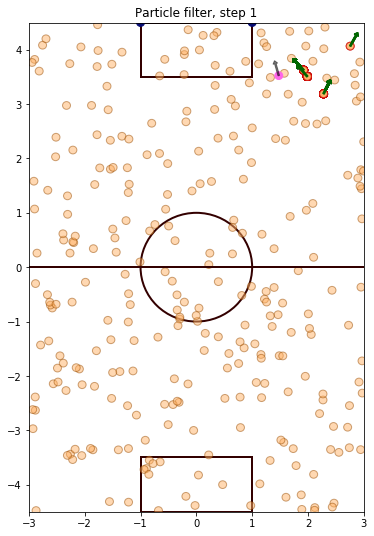

In [358]:
visualization(robot, 1, p, pre, factor = 7 )

In [1265]:
w, pre = pf.resampling(measurement, landmarks)
robot.update_coord(pre)

z =  [2.6460027951783873]
1.710900301849096 0.3 1.0115611751787004
2.9655135183332746 0.3 6.926216539816564
z =  [2.6178865382925864]
1.710900301849096 0.3 1.0115611751787004
2.9655135183332746 0.3 6.926216539816564
z =  [2.575687563411969]
1.710900301849096 0.3 1.0115611751787004
2.9655135183332746 0.3 6.926216539816564
z =  [2.5036065688342526]
1.710900301849096 0.3 1.0115611751787004
2.9655135183332746 0.3 6.926216539816564
z =  [3.026350367021046]
1.710900301849096 0.3 1.0115611751787004
2.9655135183332746 0.3 6.926216539816564
z =  [2.9376635539130556]
1.710900301849096 0.3 1.0115611751787004
2.9655135183332746 0.3 6.926216539816564
z =  [3.1578928374082693]
1.710900301849096 0.3 1.0115611751787004
2.9655135183332746 0.3 6.926216539816564
z =  [2.5739981923722413]
1.710900301849096 0.3 1.0115611751787004
2.9655135183332746 0.3 6.926216539816564
z =  [2.947349342642156]
1.710900301849096 0.3 1.0115611751787004
2.9655135183332746 0.3 6.926216539816564
z =  [2.991713116314415]
1.7109

In [785]:
def get_landmarks(fields):
    #landmarks = [[2,1],[4,1],[0,0]]
    landmarks = [[2,1],[2,0],[3,2.5]]
   
    return landmarks

In [219]:
robot1 = Robot()
robot1.set_coord(2.0, 3.0, 0.0)

In [223]:
landmarks = [[-1,4.5],[1,4.5]]


In [ ]:
landmarks  = [[]]

In [31]:
def uangle(x2,y2,x1 = 0.0,y1 = 1.0):
    return math.acos((x1*x2+y1*y2)/(math.sqrt(x1**2+y1**2)*math.sqrt(x2**2+y2**2)))

In [221]:
z = []
for i in range(len(landmarks)):
    dist = math.sqrt((robot1.x - landmarks[i][0]) ** 2 + (robot1.y - landmarks[i][1]) ** 2)
    dist += random.gauss(0.0, robot1.sense_noise)
    angle = robot1.orientation + uangle( landmarks[i][0] - robot1.x, landmarks[i][1]-robot1.y, math.cos(robot1.orientation),
                                        math.sin(robot1.orientation))
    #angle += random.gauss(0.0, robot1.sense_noise)
    z.append([dist,angle])


In [277]:
for k in pre:
    print(k[0].x)

1.2470659119723064
1.2470659119723064
1.2470659119723064
1.2470659119723064
0.8885940549112487
1.2470659119723064
1.2470659119723064
1.2470659119723064
1.2470659119723064
1.2470659119723064
1.2470659119723064
0.9836685567638167
1.2470659119723064
1.2470659119723064
1.2470659119723064
1.2470659119723064
1.2470659119723064
1.2470659119723064
1.2470659119723064
1.2470659119723064
1.2470659119723064
1.2470659119723064
1.2470659119723064
1.2470659119723064
1.2470659119723064
1.2470659119723064
1.2470659119723064
0.8885940549112487
1.2470659119723064
1.2470659119723064
1.2470659119723064
1.2470659119723064
1.2470659119723064
1.2470659119723064
1.2470659119723064
1.2470659119723064
1.2470659119723064
1.2470659119723064
1.2470659119723064
1.2470659119723064
1.2470659119723064
1.2470659119723064
1.2470659119723064
1.2470659119723064
1.2470659119723064
1.2470659119723064
1.2470659119723064
1.2470659119723064
1.2470659119723064
1.2470659119723064
1.2470659119723064
1.2470659119723064
1.2470659119

In [27]:
landmarks = z

In [28]:
landmarks2

[[1.297780009121559, 0.7853981633974484],
 [2.9954007494341717, 0.3217505543966423]]

In [1621]:
def get_measurements(landmarks, i):
    x = 0
    y = 0
    x = (landmarks[i][0] - landmarks_rob[i][0] + random.gauss(0.0, 1.5))
    y = ( landmarks[i][1] - landmarks_rob[i][1] + random.gauss(0.0, 1.5))
    return [x,y]

In [1636]:
get_measurements(landmarks, 1)

[-2.4758426694856444, 3.0784403773394597]

In [38]:
landmarks

[[-1, 4.5], [1, 4.5]]

In [35]:
measurement = z

In [225]:
measurement2 = z

In [169]:
xer = Field(field)

In [170]:
xer.w_width

6

In [224]:
z


[[3.162868755835978, 2.677945044588987],
 [1.665373697724714, 2.1587989303424644]]

In [348]:
for i in range (100):
    print(random.gauss(0.0, 1.0))

1.0575048615589078
0.5859055717334358
-0.12752968254049774
1.5955018268669208
-0.4441124636147076
-2.0393317933022765
-0.31684094893626347
0.4569477514249651
-1.1332513527240817
-0.9923320029318814
-0.899990806113692
0.7055887480368069
-2.097330463645968e-05
-0.23303524477755813
0.7728888642202176
0.5026269404309339
-1.6921219866854986
-0.49161525694261055
-0.3579818247948678
1.3935460843480139
0.13170122429566702
0.5562117234431996
-1.1620052851723408
0.03462225004128468
-0.41099947946482335
-0.0739605445864564
-1.0764734391141704
-0.8380714968629366
0.7845413017878763
0.8946241477273945
-0.7594672852435534
1.8591783983648977
-2.363514266006674
-2.1147722392474857
0.4350641271304527
1.8483549245039776
1.1065110145211436
-1.2327802113461883
0.8443798779127726
0.5904646203191626
-0.406236880721238
-1.6805225984422503
0.5012883245932864
1.098816686260819
-0.09675172185469927
2.029802600513499
-0.640740239033508
1.1881939316858914
0.8843516268387961
0.5614940547289605
-0.556033333940568
-

In [29]:
with open("landmarks.json", "r") as f:
        landmarks = json.loads(f.read())['landmarks']

In [31]:
type(landmarks)

list

In [20]:
json.loads(f.read())

JSONDecodeError: Expecting value: line 1 column 1 (char 0)